In [1]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [2]:
import pandas as pd
from urlparse import urlparse
import tldextract
from collections import Counter
import jieba
import json
import math
import numpy as np
from time import time

In [3]:
from gensim.models import Word2Vec, KeyedVectors
model = KeyedVectors.load_word2vec_format('../data/w2v/huizhou_model_format_v2.bin', binary=False)

In [4]:
df = pd.read_csv('../data/clean/huizhou-web_v3.csv')

In [5]:
df.info()

In [6]:
import re
match = re.compile('([a-zA-Z_0-9_=_#_&_/])') #remove letters, numbers, and special characters in the article body
#match = re.compile('([a-zA-Z_0-9])') #remove all of english letters and numbers
def classifier_filters(s):
    return match.sub(r' ', s) 

In [7]:
def filter_combined(x):
    s = x.split()
    r = [t for t in s if (t.strip()) > 0 and t.strip() not in keyword_stop_words]
    t = ' '.join(r)
    ret = classifier_filters(t)
    #print 'before -----', t
    #print 'after ------', ret
    return ret   

In [8]:
huizhou_stop_words = [u'的', u'了', u'在', u'是', u'安徽', u'和', u'有', u'我', u'年', u'上', u'他', u'我们', u'及',
                      u'为', u'与', u'人', u'也', u'于', u'中', u'就', u'都', u'在线', u'等', u'不', u'网站', u'你', 
                      u'一个', u'到', u'之', u'对', u'说', u'进入', u'后', u'月', u'将', u'时', u'又', u'被', u'会员'
                     u'版权', u'论坛', u'以', u'而', u'着', u'下', u'这', u'但', u'要', u'或', u'首页', u'这', u'更',
                     u'地', u'从', u'卡', u'来', '多', u'日', u'她', u'还', u'联系', u'那', u'一处', u'一直', u'个', 
                     u'向', u'并', u'曾', u'这样', u'里', u'合肥', u'推荐', u'专栏', u'相关', u'当前', u'所有', u'中心'
                     u'频道', u'编辑', u'位置', u'第一', u'社区', u'看', '中安', u'安徽省', u'大', u'许可证', u'许可',
                     u'让', u'没有', u'什么', u'其', '请', '该', '用', '积分', u'凤阳', u'一篇', u'版权', u'县', u'这里',
                      u'就是', u'生于', u'他们', u'它', u'男', u'去', u'会', u'由', u'一', u'做', u'所', u'毕业', u'一种',
                     u'协会会员', u'把', u'能', u'至', u'这个', u'自己', u'黄山市', u'出', u'如', u'如',u'可以', u'很',
                     u'成为', u'好', u'先生', u'中国', u'集团', u'江淮', u'网', u'特色', u'全国', u'新', u'作为', u'师专',
                     u'则', u'重要', u'们', u'给', u'这些', u'过', u'安', u'最', u'现在', u'得', u'国家']

s = ' '.join(huizhou_stop_words)
#s = u'444 （）'

In [9]:
import unicodedata
def remove_non_chinese(s):
    r = [c for c in s if unicodedata.category(c).startswith('L')]
#print r
    return ''.join(r)
#print remove_non_chinese(s)

hz_dict = dict(zip(words, fq))

In [10]:
def ch_title_letters_removal(x):
    #print 'coming', x
    t = x.strip('  ')
    if(len(t)) == 0:
        return None
    
    if(len(x) > 0):
        #s = x.strip()
        s = remove_non_chinese(x)
        if len(s) > 0 and s not in huizhou_stop_words:
            return s.strip()
        else:
            return None
    return None

In [11]:
#calculate count using Counter
def map_document_word_cnt(x):
    n = 800
    del_cnt = 0
    count = Counter(x.decode('utf-8').split())
    top_n = count.most_common (n)
    words, cnt = zip(*top_n)
    for word in words:
        ret = ch_title_letters_removal(word)
        if ret == None or len(ret) == 0:
            del count[word]
            del_cnt +=1

    print 'deleted cnt', del_cnt
    top_n = count.most_common (200)
    return top_n

In [12]:
global idx
idx = 0
def map_words_fq(x, normalize=True): 
    global idx
    print idx
    idx += 1
    s = x.decode('utf-8').split()
    #print 'vect ---', len(s), s
    ret = [ch_title_letters_removal(item) for item in s if len(item) > 0 and ch_title_letters_removal(item) != None]
    #print 'ret ---', ret, len(ret)
    count = Counter(ret)
    
    #print 'count', len(count)

    if len(count) > 1:
        top_N = count.most_common(100)
        
        words, cnt = zip(*top_N)
        tot = sum(cnt)
        hz_fq = [float(i)*1.0/tot for i in cnt]
        dictionary = dict(zip(words, hz_fq))
        
        #print 'going ---'
        #*words, cnt = zip(*top_200)
        #return dict(zip(words, cnt))
        return dictionary
    else:
        #print 'warning'
        return None

In [28]:
def map_word2vec_centroid(x):
    global model
    x = x.items() #dict to tuple
    # remove out-of-vocabulary words
    doc = [(word, fq) for word, fq in x if word in model.vocab]   
    if len(doc) == 0:
        #print x
        return None
    #words, fq = zip(*doc)
    ret = [model[x] * y for x, y in doc]
    
    val = np.mean(ret, axis=0)
    sum1 = np.sum([val**2])
    
    r = val/math.sqrt(sum1)
        
    #print ret
    
    #doc = [word for word in doc if word in word2vec_model.vocab]
    return r

In [16]:
def map_unserialize (x, eval_val = False):
    #print '----- in'
    #print x
    d = dict()
    s = x.strip('{}')
    #s = s.strip('[]')
    ret = s.split(',')
    
    #print ret
    for t in ret:
        r = t.split(':')
        #print r[0], r[1]
        key = eval(r[0].decode('utf-8'))
        d[key] = float(r[1])
    #print len(ret)
    #print 'split -----'
    #print ' '.join(ret)
    return d

In [27]:
df.info()

In [17]:
t0 = time()
df['words_fq'] = df.content_seg.map(lambda x: map_words_fq(x))
#df['words_fq'] = df.s_vec.map(lambda x: map_unserialize(x))
print time() - t0 

In [18]:
df = df.dropna(subset =['words_fq'])

In [29]:
t0 = time()
df['w2v_centroid'] = df.words_fq.map(lambda x: map_word2vec_centroid(x))
time() - t0

30.456953048706055

In [20]:
df['content_len'] = df['content'].str.len()

In [21]:
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline 

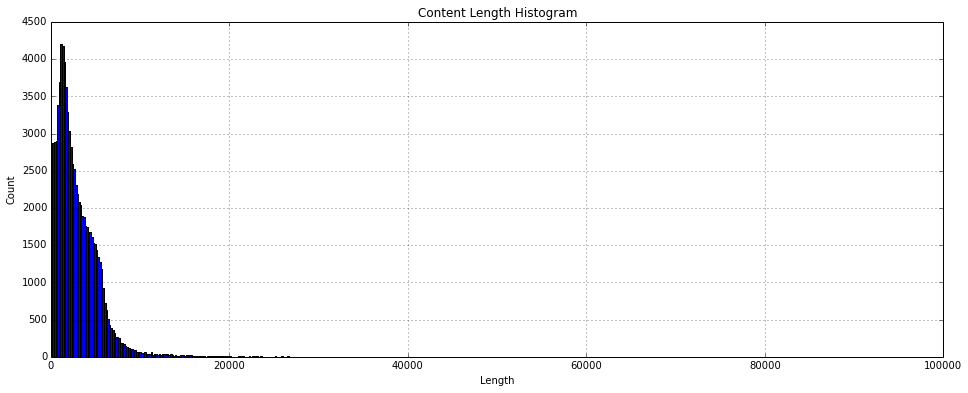

In [22]:
df['content_len'].hist(bins=500, figsize= (16, 6))
plt.title('Content Length Histogram')
plt.xlabel('Length')
plt.ylabel('Count')

In [23]:
test = df[df['content_len'] < 150]

In [24]:
test.info()

In [30]:
df = df[df['content_len'] >= 150]

In [31]:
df.info()

In [32]:
def get_cosine2(vec1, vec2):    
    numerator = np.sum([a*b for a,b in zip(vec1,vec2)]) 
    return float(numerator)

In [34]:
t0 = time()
hz_vec = model[u'徽州']*0.3 + model[u'文化']*0.3 + model[u'徽文化']*0.4
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)
    
df['hzwh_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

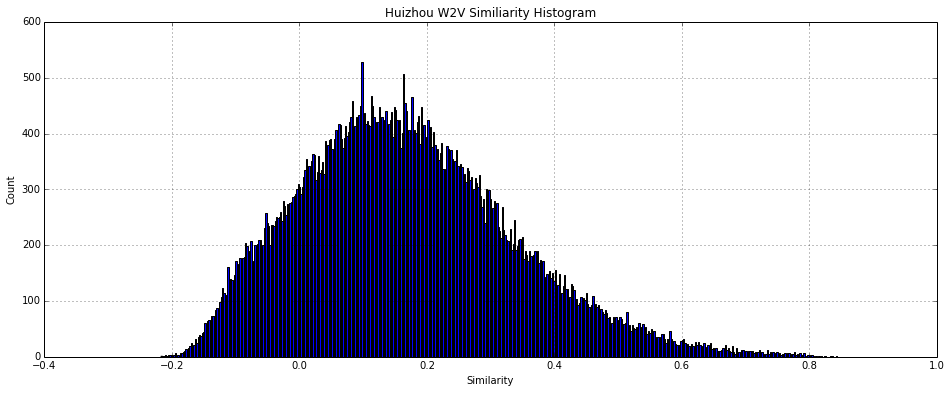

In [35]:
df['hzwh_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [36]:
hz_sim = df['hzwh_w2v_sim'].values.argsort()[::-1]

In [38]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzwh_w2v_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzwh_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [39]:
msk1 = df['content'].str.contains('徽州') 
msk2 = df['content'].str.contains('徽文化') 
msk = msk1 | msk2
df_check = df[msk]

In [40]:
df_check.info()

In [41]:
docs = df_check['content_seg']

In [42]:
hz_words_fq = map_words_fq(' '.join(docs))

In [43]:
print ' '.join(hz_words_fq.keys())

In [46]:
hz_vec = map_word2vec_centroid(hz_words_fq)
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)

In [47]:
t0 = time()
df['hzwh_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

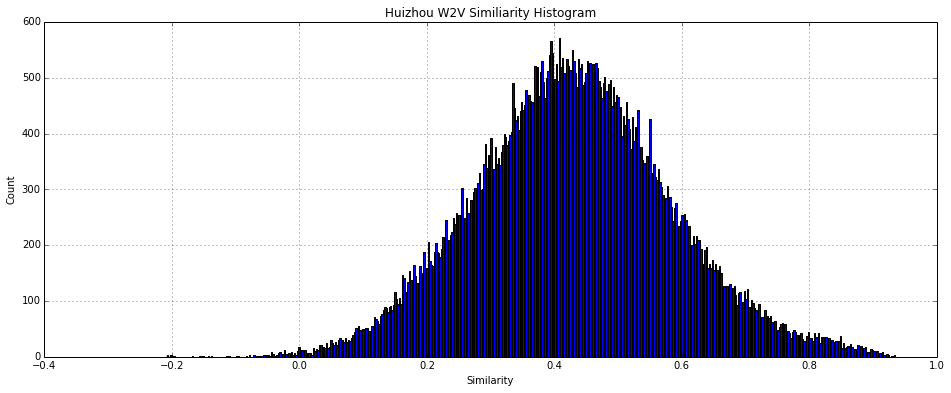

In [48]:
df['hzwh_w2vs_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [49]:
hz_sim = df['hzwh_w2vs_sim'].values.argsort()[::-1]

In [50]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzwh_w2vs_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzwh_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [52]:
t0 = time()
hz_vec = model[u'徽派']*0.5 + model[u'建筑']*0.5
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)
df['hzjz_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [53]:
hz_sim = df['hzjz_w2v_sim'].values.argsort()[::-1]

In [54]:
df['hzjz_w2v_sim'].max()

0.82953476905822754

In [56]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzjz_w2v_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzjz_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [57]:
msk1 = df['content'].str.contains('徽派') 
msk2 = df['content'].str.contains('建筑') 
msk = msk1 | msk2
df_check = df[msk]

In [58]:
docs = df_check['content_seg']

In [59]:
hz_words_fq = map_words_fq(' '.join(docs))

In [60]:
hz_vec = map_word2vec_centroid(hz_words_fq)
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)

In [61]:
t0 = time()
df['hzjz_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [62]:
hz_sim = df['hzjz_w2vs_sim'].values.argsort()[::-1]

In [63]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzjz_w2vs_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzjz_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [64]:
t0 = time()
hz_vec = model[u'徽州']*0.4 + model[u'继承']*0.3 + model[u'遗产']*0.3
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)
df['ycjc_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [65]:
df['ycjc_w2v_sim'].max()

0.87996810674667358

In [66]:
hz_sim = df['ycjc_w2v_sim'].values.argsort()[::-1]

In [67]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['ycjc_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['ycjc_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

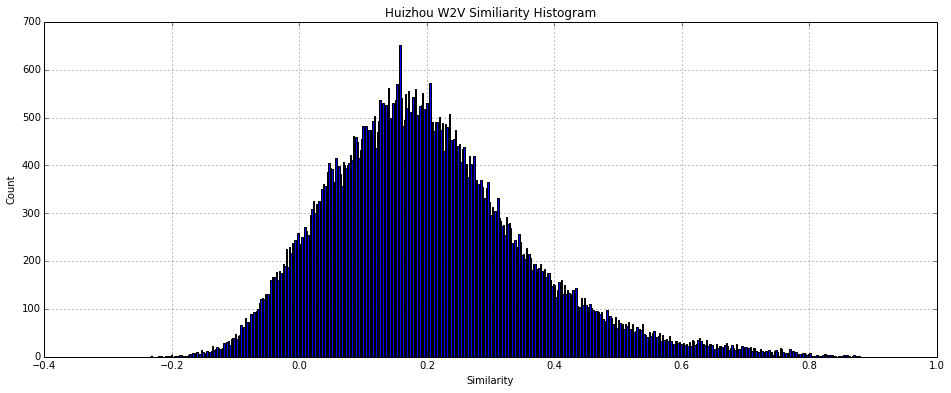

In [68]:
df['ycjc_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [69]:
msk1 = df['content'].str.contains('徽州') 
msk2 = df['content'].str.contains('继承') 
msk3 = df['content'].str.contains('遗产') 

msk = msk1 | msk2 | msk3
df_check = df[msk]

In [70]:
docs = df_check['content_seg']

In [71]:
hz_words_fq = map_words_fq(' '.join(docs))

In [72]:
hz_vec = map_word2vec_centroid(hz_words_fq)
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)

In [73]:
t0 = time()
df['ycjc_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [74]:
hz_sim = df['ycjc_w2vs_sim'].values.argsort()[::-1]

In [75]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['ycjc_w2vs_sim'] > 0.80 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['ycjc_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [76]:
t0 = time()
hz_vec = model[u'徽州']*0.5 + model[u'雕刻']*0.5
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)
df['hzdk_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [77]:
hz_sim = df['hzdk_w2v_sim'].values.argsort()[::-1]

In [78]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzdk_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzdk_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

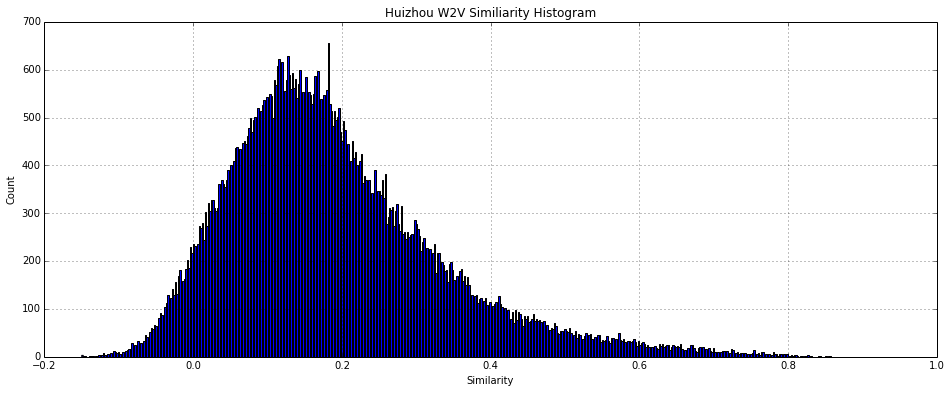

In [79]:
df['hzdk_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [80]:
msk1 = df['content'].str.contains('徽州') 
msk2 = df['content'].str.contains('雕刻') 

msk = msk1 | msk2
df_check = df[msk]

In [81]:
docs = df_check['content_seg']

In [82]:
hz_words_fq = map_words_fq(' '.join(docs))

In [83]:
hz_vec = map_word2vec_centroid(hz_words_fq)
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)

In [84]:
t0 = time()
df['hzdk_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [85]:
hz_sim = df['hzdk_w2vs_sim'].values.argsort()[::-1]

In [86]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hzdk_w2vs_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hzdk_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [87]:
t0 = time()
hz_vec = model[u'徽派']*0.5 + model[u'艺术']*0.5
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)
df['hpys_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [88]:
hz_sim = df['hpys_w2v_sim'].values.argsort()[::-1]

In [89]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hpys_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hpys_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

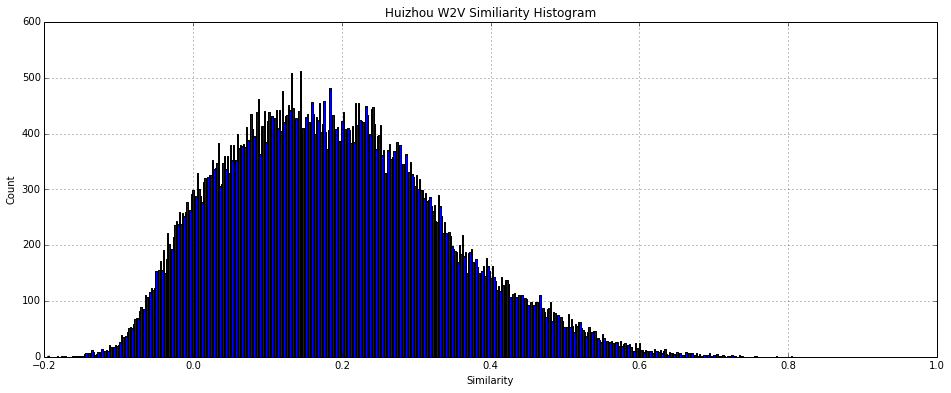

In [90]:
df['hpys_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [91]:
msk1 = df['content'].str.contains('徽派') 
msk2 = df['content'].str.contains('艺术') 

msk = msk1 | msk2
df_check = df[msk]

In [92]:
docs = df_check['content_seg']

In [93]:
hz_words_fq = map_words_fq(' '.join(docs))

In [94]:
hz_vec = map_word2vec_centroid(hz_words_fq)
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)

In [95]:
t0 = time()
df['hpys_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [96]:
hz_sim = df['hpys_w2vs_sim'].values.argsort()[::-1]

In [97]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hpys_w2vs_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hpys_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [98]:
t0 = time()
hz_vec = model[u'徽剧']*0.5 + model[u'徽菜']*0.5
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)
df['hjhc_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [99]:
hz_sim = df['hjhc_w2v_sim'].values.argsort()[::-1]

In [100]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hjhc_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hjhc_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

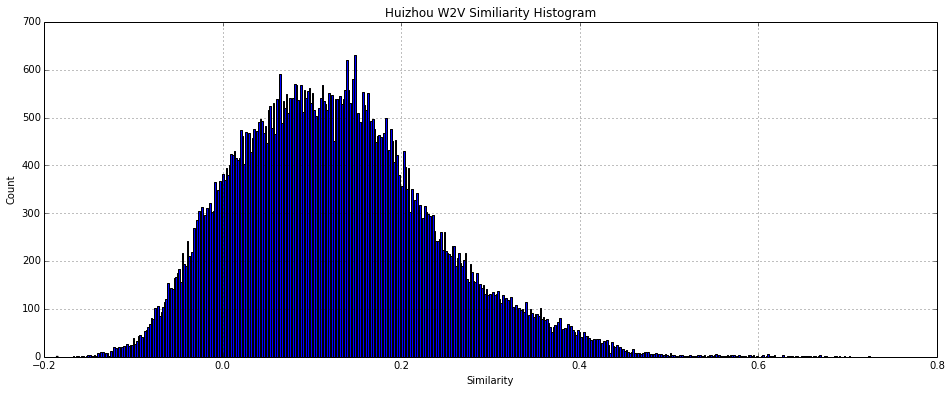

In [101]:
df['hjhc_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [102]:
msk1 = df['content'].str.contains('徽剧') 
msk2 = df['content'].str.contains('徽菜') 

msk = msk1 | msk2
df_check = df[msk]

In [103]:
docs = df_check['content_seg']

In [104]:
hz_words_fq = map_words_fq(' '.join(docs))

In [105]:
hz_vec = map_word2vec_centroid(hz_words_fq)
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)

In [106]:
t0 = time()
df['hjhc_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [107]:
hz_sim = df['hjhc_w2vs_sim'].values.argsort()[::-1]

In [108]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hjhc_w2vs_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hjhc_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [109]:
t0 = time()
hz_vec = model[u'徽商']
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)
df['hs_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [110]:
hz_sim = df['hs_w2v_sim'].values.argsort()[::-1]

In [111]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hs_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hs_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

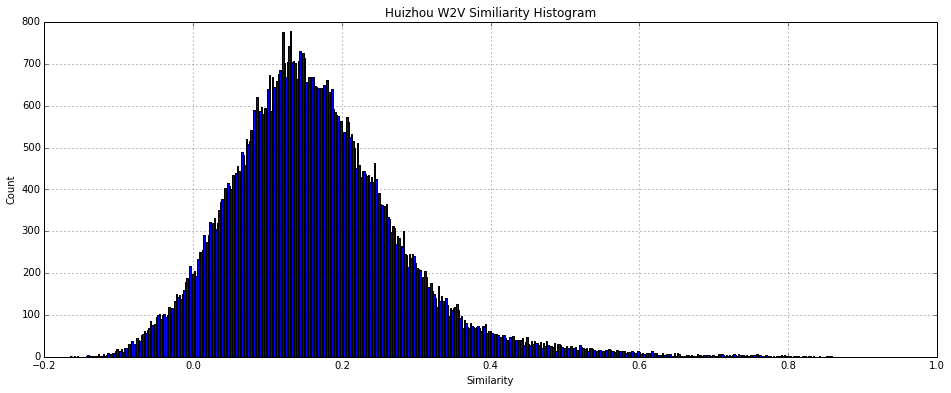

In [112]:
df['hs_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [113]:
msk1 = df['content'].str.contains('徽商') 

msk = msk1
df_check = df[msk]

In [114]:
docs = df_check['content_seg']

In [115]:
hz_words_fq = map_words_fq(' '.join(docs))

In [116]:
hz_vec = map_word2vec_centroid(hz_words_fq)
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)

In [117]:
t0 = time()
df['hs_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [118]:
hz_sim = df['hs_w2vs_sim'].values.argsort()[::-1]

In [119]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hs_w2vs_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hs_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [120]:
t0 = time()
hz_vec = model[u'新安']*0.5 + model[u'理学']*0.5
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)
df['xalx_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [121]:
hz_sim = df['xalx_w2v_sim'].values.argsort()[::-1]

In [122]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['xalx_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['xalx_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

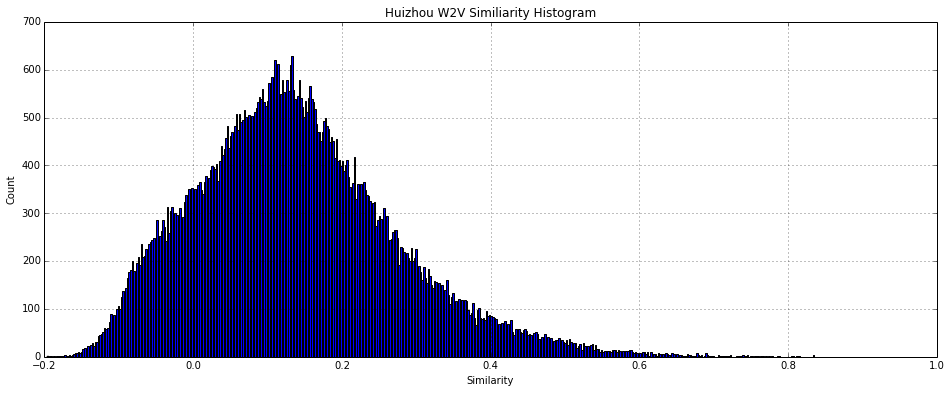

In [123]:
df['xalx_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [124]:
msk1 = df['content'].str.contains('新安') 
msk2 = df['content'].str.contains('理学') 

msk = msk1 | msk2
df_check = df[msk]

In [125]:
docs = df_check['content_seg']

In [126]:
hz_words_fq = map_words_fq(' '.join(docs))

In [127]:
hz_vec = map_word2vec_centroid(hz_words_fq)
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)

In [128]:
t0 = time()
df['xalx_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [129]:
hz_sim = df['xalx_w2vs_sim'].values.argsort()[::-1]

In [130]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['xalx_w2vs_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['xalx_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [131]:
t0 = time()
hz_vec = model[u'徽学']*0.5 + model[u'研究']*0.5
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)
df['hxyj_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [132]:
hz_sim = df['hxyj_w2v_sim'].values.argsort()[::-1]

In [133]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hxyj_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hxyj_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

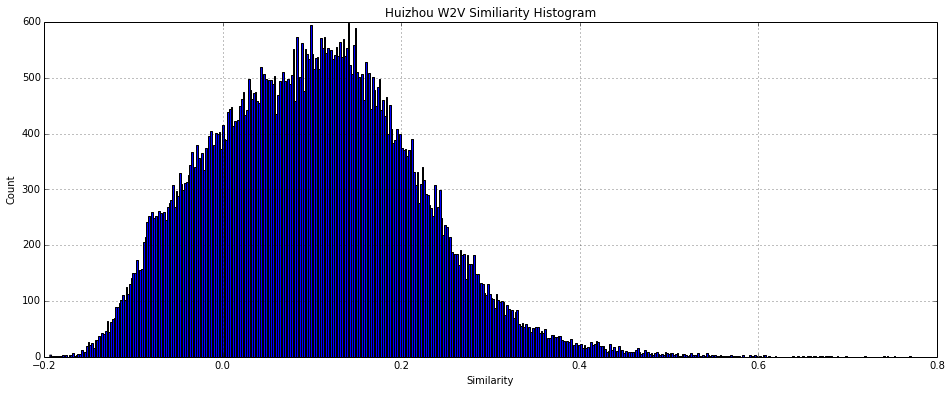

In [134]:
df['hxyj_w2v_sim'].hist(bins=500, figsize= (16, 6))
plt.title('Huizhou W2V Similiarity Histogram')
plt.xlabel('Similarity')
plt.ylabel('Count')

In [135]:
msk1 = df['content'].str.contains('徽学') 
msk2 = df['content'].str.contains('研究') 

msk = msk1 | msk2
df_check = df[msk]

In [136]:
docs = df_check['content_seg']

In [137]:
hz_words_fq = map_words_fq(' '.join(docs))

In [138]:
hz_vec = map_word2vec_centroid(hz_words_fq)
sum1 = np.sum([hz_vec**2])    
hz_vec = hz_vec/math.sqrt(sum1)

In [139]:
t0 = time()
df['hxyj_w2vs_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [140]:
hz_sim = df['hxyj_w2vs_sim'].values.argsort()[::-1]

In [141]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['hxyj_w2vs_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title_c']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['hxyj_w2vs_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [142]:
def map_serialize(x):
    #print len(x)
    ret = []
    idx = 0
    for v in x:
        #print idx, v
        ret.append(str(v))
        idx += 1
    #print ret
    return ','.join(ret)

In [143]:
df['w2v_centroid_s'] = df.w2v_centroid.map(lambda x: map_serialize(x))

In [151]:
df['title'] = df['title_c']

In [144]:
df.to_csv('../data/clean/huizhou_web_v4.csv', encoding='utf-8', index=False)

In [263]:
df_out = df[['url', 'title', 'summary', 'key_words', 'w2v_centroid_s', 'hzwh_w2v_sim', 'hzjz_w2v_sim', 
             'ycjc_w2v_sim', 'hzdk_w2v_sim', 'hpys_w2v_sim', 'hjhc_w2v_sim', 'hs_w2v_sim', 'xalx_w2v_sim', 
             'hxyj_w2v_sim', 'hzwh_w2vs_sim', 'hzjz_w2vs_sim', 'ycjc_w2vs_sim', 'hzdk_w2vs_sim',
             'hpys_w2vs_sim', 'hjhc_w2vs_sim', 'hs_w2vs_sim', 'xalx_w2vs_sim', 'hxyj_w2vs_sim']]

In [264]:
df_out.to_csv('../data/clean/huizhou-web-slim_v4.csv', encoding='utf-8', index=False)

In [262]:
df_out.info()

In [147]:
df.info()

In [149]:
df_full_out = df[['url', 'title_c', 'summary', 'key_words', 'content', 'content_seg']]

In [150]:
df_full_out.to_csv('/Users/nhu2000/projects/SimilarSearch/data/clean/huizhou_full_v4.csv', encoding='utf-8', index=False)

In [160]:
t0 = time()
hz_vec = model[u'许村']
print hz_vec
df['check_w2v_sim'] = df.w2v_centroid.map(lambda x: get_cosine2(hz_vec, x))
print time() - t0

In [155]:
hz_sim = df['check_w2v_sim'].values.argsort()[::-1]

In [157]:
idx = 0
for i in hz_sim:
    if df.iloc[i]['check_w2v_sim'] > 0.50 and idx < 10:
        title = df.iloc[i]['title']
        content = df.iloc[i]['content']
        sim_val = df.iloc[i]['check_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  df.iloc[i]['url']
        print content
        print '--------------'

In [ ]:
[-1.12238002 -1.091061    1.76988399  2.66827297  0.96279502 -0.73301703
 -0.45821801  0.97046399 -2.26986504 -0.80264401  0.24297599  0.88782603
  0.48647001 -0.090728    1.18117297 -0.96079302  2.11178207 -1.61561203
  0.022533   -0.86853999  1.86277795 -1.89101303 -0.95839    -0.68978101
 -2.32177806  2.43449092  1.62260997  1.20086801  1.22544503 -2.38687992
 -0.75809199  1.32871306  0.90218502 -0.732602   -1.50391495 -1.72873795
 -0.88549203 -0.43183199  1.11181498 -2.14988303 -1.00682294  0.566414
  0.72636998 -2.11114693  1.08733106  0.704458   -0.50669301 -1.81752002
 -0.24684601  0.96173197  2.01574898  0.09849    -0.29390901  1.90128398
  0.072904    2.53772092 -0.244515   -1.42193401  0.66484702 -1.11893797
 -0.300937   -1.06850398 -1.60321796 -0.140315   -0.73214197  0.52109802
 -0.028737    0.55364001  0.60184997 -1.44752896  1.29442799  0.199036
 -0.74549901 -0.214762    0.15526    -1.36657906 -0.058014   -0.087662
 -0.36995399 -0.57150602 -1.34059894 -0.248257   -0.205272    1.17129898
 -0.792395    0.95963401 -1.90589595 -2.03502488  0.73571002  0.87167102
 -1.45685303 -0.048016   -0.371903   -2.23889303 -1.07460201  0.170486
  0.49401     0.633663   -1.43831503  1.25879502  0.88857198  0.681306
  1.44569302  0.94104701 -0.091744    1.27197802 -0.16035201 -0.883829
 -1.31371498  0.29662299  0.017848    0.56527698 -0.233027   -0.155526
 -1.91576004  0.75709802 -0.53403401 -0.17742001 -0.011314   -1.43560696
 -0.556198    0.543571   -1.23906696 -1.49058902 -1.11923003  0.59723002
  0.74503201 -1.72788799 -1.23964906 -0.194857    0.73088801  0.74381399
  2.16396308 -0.226349    1.51989698  0.85970598 -0.35181701 -1.48268998
  0.53765899 -1.00849295 -1.72479701  1.28866804 -1.59591305  0.57403702
 -0.744178    0.50365299 -1.47585106 -2.09577298 -0.62940198  0.167358
 -0.90899402  0.65579301  0.12551001  0.77650797  0.51483899  0.38927299
 -0.155497   -0.55383497 -2.4271121  -1.34285998  0.41503301  0.45621699
 -3.232831   -0.55843002  0.086357   -0.24434599 -2.04667902  0.043751
 -0.73951697  0.1424      0.028633   -0.230287    1.55961597  0.39443201
  2.22905707  0.05424     0.140956    0.7744     -0.139376   -1.13157105
 -0.95656103 -1.07728195 -0.90918398 -0.99539798  1.03669906  0.246252
 -0.175658    1.00055397  0.52675301 -0.285106    1.59659505  0.023983
  2.07109094 -1.49172795 -0.94966102 -0.60499197 -0.47167     1.13505602
 -0.020553    1.18562305  1.10967696 -0.89797199  0.249042   -0.73155898
  0.41376999  1.07701302 -0.52958202  0.18081699  1.41122305  2.01281691
  1.636693   -0.418356    0.55608898 -0.40656301 -1.40620005  0.733046
  0.585347   -1.69993496  0.44282201 -0.42479801  0.148413   -1.24951601
 -0.81971002 -0.19271301 -1.35247898  0.37108299  1.81439698 -1.07865095
 -0.20172     1.11864603 -0.353769    0.087251    0.37276    -0.52506697
  0.13840701  0.555493   -0.21189    -0.044087   -0.57734603  0.994331
 -0.84407198  0.274432    1.57023597 -0.96654701  0.280958    0.94766599
  0.46625799 -1.47628105 -0.079783   -0.49992499]


In [ ]:
[  1.02237701e+00  -1.67339396e+00   3.91308010e-01   3.34244013e-01
  -6.12609029e-01  -8.46727014e-01  -9.15831983e-01  -1.29991198e+00
  -1.74890697e+00  -6.61952019e-01  -1.07439601e+00  -9.74385023e-01
   2.58098990e-01  -8.58017981e-01   2.50804007e-01   3.63673002e-01
   1.09893298e+00  -1.48361194e+00   7.43502975e-01  -1.61937997e-01
   1.48006201e+00   3.55480015e-02   1.38853705e+00   8.76326025e-01
  -8.82704020e-01  -1.24500997e-01   1.01193404e+00  -7.36069977e-02
  -8.09651017e-01  -5.31211019e-01   9.03407991e-01   1.17097998e+00
  -1.32983997e-01   3.38652015e-01  -5.25985003e-01   1.36269796e+00
  -4.48615015e-01  -1.71028495e+00  -2.47743994e-01  -1.20759702e+00
   2.10997009e+00   1.04938999e-01  -4.28097010e-01  -5.16819000e-01
  -4.70481992e-01   4.27829996e-02  -8.29012990e-01  -4.70300019e-03
   6.68197989e-01  -1.27283597e+00  -4.34854001e-01   3.93573999e-01
   1.73997000e-01  -4.79241997e-01  -5.14405012e-01   2.30348110e+00
  -1.14912105e+00  -1.01199998e-02   2.94209003e-01  -1.57068998e-01
   7.67136991e-01  -1.25421798e+00  -8.04129988e-02   1.26225400e+00
  -5.96516013e-01  -9.67853010e-01   3.29194993e-01  -4.63350005e-02
  -1.24161196e+00  -9.33125019e-01  -9.16698992e-01  -5.56528986e-01
   1.73736006e-01  -1.06776702e+00   7.94884980e-01  -1.57056904e+00
   2.60380004e-02   8.41284990e-01   2.85526991e-01   1.16607106e+00
  -1.42430103e+00  -1.34706295e+00  -8.86101007e-01   1.26703405e+00
   2.13632488e+00  -1.92745000e-01   1.16062000e-01  -9.39574003e-01
  -1.78815401e+00   1.00964105e+00  -9.89745021e-01   1.88449895e+00
   5.99527001e-01  -2.66000986e-01  -9.10674989e-01  -1.87860001e-02
  -7.40032971e-01   1.36497402e+00  -1.28735006e-01   1.13375103e+00
   6.94899976e-01   6.74407005e-01   1.34590900e+00  -1.87096998e-01
   4.91961986e-01   4.99588996e-01  -1.06178796e+00   4.98876989e-01
  -2.45030999e-01   2.12014008e+00  -6.91884995e-01   1.57765999e-01
   2.79785991e-01   7.31347024e-01   9.31860983e-01   1.08867800e+00
   1.13986504e+00   2.36891001e-01   3.88979986e-02  -3.79666001e-01
  -8.53528023e-01   7.43327022e-01  -1.11029100e+00   8.15855026e-01
  -8.40149969e-02   1.79833996e+00   8.86862993e-01   3.08113009e-01
  -6.23512983e-01   8.23189989e-02  -6.81229979e-02   1.37455001e-01
   1.13449705e+00  -1.75228798e+00   6.81420028e-01   2.22911999e-01
   4.02307004e-01   4.90099013e-01  -8.93335998e-01  -1.86712694e+00
   8.12456012e-01  -8.78736019e-01  -3.21137011e-01   7.21530020e-02
   5.89435995e-01   1.15009797e+00   4.52012002e-01  -1.66953194e+00
  -4.69956994e-01   1.51497805e+00   3.76639999e-02  -3.76004994e-01
   6.57123029e-01   7.89188981e-01  -1.06055701e+00   1.09399995e-03
  -1.32889003e-01   5.55432975e-01  -1.46594906e+00  -6.53221011e-01
  -8.69921982e-01   4.42099990e-03  -4.22087997e-01  -3.12815011e-01
   1.42602801e+00  -3.34408998e-01   5.64866006e-01   9.97946024e-01
   1.55599105e+00   1.55024397e+00   5.21346986e-01  -3.40034992e-01
   1.31729007e-01  -1.14307001e-01  -8.85438025e-01  -1.25351095e+00
   4.27599996e-02  -2.44195998e-01  -7.23330021e-01  -9.98890027e-02
  -7.00668991e-01  -9.06394005e-01  -8.53187025e-01  -1.67692304e+00
  -2.16877997e-01  -1.94913000e-01  -2.40841001e-01   8.43295991e-01
  -3.34174007e-01  -8.68043005e-01   9.45591986e-01   4.04920995e-01
   9.84381974e-01  -6.93006992e-01  -2.08018708e+00   1.06885898e+00
   1.57918799e+00   5.72302997e-01  -1.30590007e-01  -2.83517003e-01
   1.62122905e+00   1.34472203e+00   4.96414989e-01   1.21211004e+00
  -4.99727011e-01   1.54541999e-01  -8.69675994e-01   1.88752994e-01
  -5.34532011e-01   3.25154006e-01   1.06633000e-01  -4.00245994e-01
  -6.39917016e-01  -3.38950008e-02  -3.16294014e-01   6.77442014e-01
  -2.68027008e-01  -6.29384995e-01  -2.37830997e-01   6.00488007e-01
  -1.72675997e-01  -7.05222011e-01   5.22464991e-01   6.48080036e-02
  -1.77991003e-01  -6.99427009e-01   3.04441005e-01   1.15340698e+00
   1.16450000e+00  -4.20560986e-01   1.26380098e+00  -9.35006976e-01
  -4.08950001e-01   4.08663988e-01  -1.87417495e+00   1.43563002e-01
  -1.06211495e+00  -4.67079014e-01  -7.10090995e-01  -1.97276103e+00
  -8.49883020e-01  -8.99540007e-01  -1.46384704e+00  -6.33799016e-01
  -1.61783993e-01   1.37459600e+00   4.65478987e-01  -1.54368305e+00
   4.81635988e-01  -7.16584027e-01]

In [162]:
tt = '许村'
for t in tt.decode('utf-8'):
    print t

In [164]:
model[tt.decode('utf-8')]

array([-1.12238002, -1.091061  ,  1.76988399,  2.66827297,  0.96279502,
       -0.73301703, -0.45821801,  0.97046399, -2.26986504, -0.80264401,
        0.24297599,  0.88782603,  0.48647001, -0.090728  ,  1.18117297,
       -0.96079302,  2.11178207, -1.61561203,  0.022533  , -0.86853999,
        1.86277795, -1.89101303, -0.95839   , -0.68978101, -2.32177806,
        2.43449092,  1.62260997,  1.20086801,  1.22544503, -2.38687992,
       -0.75809199,  1.32871306,  0.90218502, -0.732602  , -1.50391495,
       -1.72873795, -0.88549203, -0.43183199,  1.11181498, -2.14988303,
       -1.00682294,  0.566414  ,  0.72636998, -2.11114693,  1.08733106,
        0.704458  , -0.50669301, -1.81752002, -0.24684601,  0.96173197,
        2.01574898,  0.09849   , -0.29390901,  1.90128398,  0.072904  ,
        2.53772092, -0.244515  , -1.42193401,  0.66484702, -1.11893797,
       -0.300937  , -1.06850398, -1.60321796, -0.140315  , -0.73214197,
        0.52109802, -0.028737  ,  0.55364001,  0.60184997, -1.44

In [244]:
msk = df['content'].str.contains('许村')

In [249]:
d = df[msk]

In [250]:
d.info()

In [251]:
for t in d['content']:
    if u'许村' in t:
        print t

In [238]:
df.info()

In [199]:
def map_check(x):
    if u'许村人报到帖' in x:
        return None
    else:
        return True

In [200]:
df['check'] = df.title.map(lambda x: map_check(x))

In [227]:
df.info()

In [202]:
df = df.dropna(subset =['check'])

In [226]:
df = df.dropna(subset =['summary'])

In [260]:
df = df.drop_duplicates(['summary'])

In [253]:
df0.info()

In [254]:
df.info()

In [258]:
df2 = df.drop_duplicates(['key_words'])

In [259]:
df2.info()

In [274]:
msk = df['key_words'].str.contains('许村')

In [275]:
check = df[msk]

In [276]:
check.info()

In [289]:
for t in check['key_words']:
    print t

In [277]:
for t in check['key_words']:
    print t

In [292]:
def key_words_dict(x):
    ret = dict()
    for t in x:
        print t
        ret[t[0]] = t[1]
    return ret

In [330]:
check['key_words_dict'] = check.key_words_s.map(lambda x: key_words_dict(x))

In [331]:
kw_dict = check['key_words_dict']

In [327]:
key_words_dict(check.iloc[0]['key_words_s'])

{u'\u4e00\u5b57\u6392\u5f00': 0.1016183538592233,
 u'\u4e00\u6ce2': 0.07433505583796117,
 u'\u4e00\u8d77': 0.04730076764941747,
 u'\u4e0d\u5c11': 0.04897656890019418,
 u'\u4e24\u4eba': 0.11607871995650486,
 u'\u4e24\u961f': 0.09241408754660194,
 u'\u4e2d\u592e': 0.050133073463300974,
 u'\u4e2d\u95f4': 0.05705310840970874,
 u'\u4e4b\u4e0b': 0.06016279070252427,
 u'\u4ea2\u8fdb': 0.09278516728271845,
 u'\u4f17\u4eba': 0.05649111042524272,
 u'\u4f17\u5200': 0.11606570391165048,
 u'\u4f17\u591a': 0.057333699336699025,
 u'\u4f20\u7edf': 0.05197609110864078,
 u'\u4fa7\u76ee': 0.09678497106067963,
 u'\u5217\u961f': 0.09488876958184465,
 u'\u524d\u53bb': 0.06693186820524272,
 u'\u5355\u4eba': 0.08864070900495145,
 u'\u53d8\u6362': 0.07422259815747573,
 u'\u53ea\u89c1': 0.055351586935533985,
 u'\u5408\u529b': 0.0792631587815534,
 u'\u549a\u549a': 0.08670742089708738,
 u'\u559c\u5e86': 0.08839696219786407,
 u'\u559d\u5f69': 0.09343700517436893,
 u'\u56db\u5c81': 0.09623003500398059,
 u'\u56f4\u8

In [348]:
res = model.most_similar(u'许村', topn=100)

In [351]:

for t in res:
    print t[0], t[1]

In [319]:
def map_unserialize_kw (x, eval_val = False):
    #print '----- in'
    #print x
    d = dict()
    #s = x.strip('{}')
    s = x.strip('[]')
    ret = s.split(',')
    
    print len(ret)
    print ret
    for t in ret:
        s = t.strip('(')
        print 
        r = t.split(',')
        #print r[0], r[1]
        key = eval(r[0].decode('utf-8'))
        d[key] = float(r[1])
    #print len(ret)
    #print 'split -----'
    #print ' '.join(ret)
    return d

In [320]:
map_unserialize_kw(check.iloc[0]['key_words'])

SyntaxError: invalid syntax (<string>, line 1)

In [325]:
import jieba.analyse
jieba.analyse.set_stop_words('../data/stop_words/chinese_stops.txt')

In [323]:
def map_get_key_words(t, x, norm=True):
    s0 = t.decode('utf-8')
    s1 = x.encode('utf-8').decode('utf-8')
    s2 = [s0, s1]
    s3 = ' '.join(s2)
    return jieba.analyse.extract_tags(s3, topK=100, withWeight=True)

In [326]:
check['key_words_s'] =  map(map_get_key_words, check['title'],check['summary'])

In [332]:
class Toolbox (object):
    def __init__(self):
        self.init = 1
        
    def sort_dict (self, d, max=50):
        t = sorted(d.items(), key=lambda x: (-x[1], x[0]))
        return t[:max]
    
    def add_dict (self, x, y):
        d = { k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y) }
        return d
    
    def create_dict(self, k1, v1, filters = True):
        if filters == True:
            k1_list0 = k1.strip('()').split(',')
            v1_list0 = v1.strip('()').split(',')
            #print v1_list0
            #print k1_list0
            k1_list1 = filter(None, k1_list0)        
            v1_list1 = filter(None, v1_list0)
        else:
            k1_list1 = k1
            v1_list1 = v1
        
        #print ' '.join(k1_list1)
        k2_list1 = [item.decode('utf-8') for item in k1_list1]
        v2_list1 = [float(item) for item in v1_list1]

    def create_vec(self, k1, v1):
        return (zip(k1, v1))
    
    def get_dict_top_n(self, d, max=50):
        ret = self.sort_dict(d, max)
        words, fq = zip(*ret)
        sum_up = sum(fq)
        fq_normalized = tuple(item/sum_up for item in fq)
        
        return dict(zip(words, fq_normalized))
    
    #calculate cosine between two dictionaries
    def get_sim(self, vec1, vec2):
        
        #get intersection
        intersection = set(vec1.keys()) & set(vec2.keys())
        
        #print intersection
        numerator = sum([vec1[x] * vec2[x] for x in intersection])

        #print 'num ---', numerator
        #print vec1.keys()
        #print vec1.values()
        #print vec2.keys()
        #print vec2.values()        
        
        sum1 = sum([vec1[x]**2 for x in vec1.keys()])
        sum2 = sum([vec2[x]**2 for x in vec2.keys()])
        denominator = math.sqrt(sum1) * math.sqrt(sum2)

        if not denominator:
            return 0.0
        else:
            return float(numerator) / denominator
        
    def sum_vects(self, vects):
        sum_vects = None
        for vec in vects:
            if sum_vects == None:
                sum_vects = vec
            else:
                sum_vects = self.add_dict(sum_vects, vec)
        #only return first 100 after additions
        #print type(sum_vecs)
        return self.get_dict_top_n(sum_vects)
    
    def unserialized(self, x, eval_val=True):
        #print '----- in'
        #print x
        d = dict()
        s = x.strip('{}')
        #s = s.strip('[]')
        ret = s.split(',')

        #print ret
        for t in ret:
            r = t.split(':')
            #print r[0], r[1]
            key = eval(r[0].decode('utf-8'))
            if eval_val == True:
                d[key] = float(r[1])
            else:
                d[key] = r[1]
        #print len(ret)
        #print 'split -----'
        #print ' '.join(ret)
        return d
        
    def get_centroid_df(self, check, t_sim, num=2000):        
        if len(check) > num:
            #sampling     
            ratio = num*1.0/len(check)
            print 'ratio ---', ratio 
            msk = np.random.rand(len(check)) < ratio
            tmp = check[msk]
            check = tmp
    
        check.info()
        check_vecs = check['s_vec']
        return self.sum_vects(check_vecs) 
    
    def set_contained_flag(self, x, y):
        x_keys = x.keys()
        y_keys = y.keys()
        for s in y_keys:
            if s in x_keys:
                return True
        return False

In [333]:
aT = Toolbox()

In [335]:
dict_ret = None
for d in kw_dict:
    if dict_ret == None:
        dict_ret = d
    else:
        dict_ret = aT.add_dict(dict_ret, d)

In [336]:
print dict_ret

In [341]:
print ' '.join(aT.get_dict_top_n(aT.sort_dict(dict_ret), 100).keys())

In [378]:
idx = 0
for t in aT.sort_dict(dict_ret):
    #print idx, t[0], t[1]
    if idx < 10:
        if t[0] in model.vocab:
            if idx == 0:
                print idx, t[0], t[1]
                vec = model[t[0]]*t[1]
            else:
                print idx, t[0], t[1]
                v = model[t[0]]*t[1]
                vec = vec + v
    idx += 1

In [388]:
#print vec
check['check_w2v_sim'] = check.w2v_centroid.map(lambda x: get_cosine2(vec, x))
print time() - t0

In [393]:
#print vec
check['check_w2v_sim'] = check.key_words.map(lambda x: model.score(x))
print time() - t0

AttributeError: 'KeyedVectors' object has no attribute 'score'

In [389]:
hz_sim = check['check_w2v_sim'].values.argsort()[::-1]

In [390]:
len(hz_sim)

132

In [392]:
idx = 0
for i in hz_sim:
    if check.iloc[i]['check_w2v_sim'] > 0.50 and idx < 100:
        title = check.iloc[i]['title']
        content = check.iloc[i]['content']
        sim_val = check.iloc[i]['check_w2v_sim']
        idx += 1
        print idx, i, title, sim_val
        print  check.iloc[i]['url']
        #print content
        print '--------------'

In [385]:
print i, check.iloc[18989]['title']

IndexError: single positional indexer is out-of-bounds

In [379]:
check.info()